In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

# LIME signature for remote model

We have to adapt the LIME signature computation to work with the MLaaS model.
We will generate first all the perturbed points that LIME needs to generate its local models.

Then, we will transform all vectors to images, save them as jpg files and upload them to the MLaaS platform. 
With that done, we will be able to perform a batch classification operation and obtain the results for each point.

In [2]:
import os
os.chdir('../')

In [25]:
import gc
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from zest import utils
from zest import train
from zest import model
from zest import lime_pytorch

In [4]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
transform = transforms.Compose([transforms.ToTensor(), normalize])

def show_torch_float(i):
    a = transforms.functional.to_pil_image(i.to(torch.uint8))
    plt.imshow(a)
    plt.show()

def show_torch_advex(img):
    # img = img / 2 + 0.5     # unnormalize
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
dataset = 'CIFAR10'
all_proxies = [
    'vgg11_bn',
    'vgg13_bn',
    'vgg16_bn',
    'vgg19_bn',
    'resnet18',
    'resnet34',
    'resnet50',
    'densenet121',
    'densenet161',
    'densenet169',
    'mobilenet_v2',
    'googlenet',
    'inception_v3'
]
all_proxies = sorted(all_proxies)

batch_size = 32
dist = ['1', '2', 'inf', 'cos']
lime_data_name = f"{dataset}_{batch_size}_lime"
save_name = lime_data_name

We need to reproduce the behavior of the `lime()` function.

```python

# Original LIME function from Zest 
def lime(self, save_name=None, cat=True):
    if save_name is None:
        save_name = self.lime_data_name
    self.net.eval()
    if self.lime_data is None:
        self.lime_data = lime_pytorch.prepare_lime_ref_data(save_name, self.trainset, self.batch_size)
    if self.lime_segment is None:
        self.lime_segment = lime_pytorch.prepare_lime_segment(save_name, self.lime_data, self.trainset)
    if self.ref_dataset is None or self.lime_dataset is None:
        self.ref_dataset, self.lime_dataset = lime_pytorch.prepare_lime_dataset(save_name, self.lime_data,
                                                                                self.lime_segment)
    self.lime_mask = lime_pytorch.compute_lime_signature(self.net, self.ref_dataset, self.lime_dataset, cat=cat)
    self.net.train()
```

In [6]:
trainset = utils.load_dataset(dataset, True, download=True)
lime_data = lime_pytorch.prepare_lime_ref_data(save_name, trainset, batch_size)

Files already downloaded and verified


In [7]:
lime_segment = lime_pytorch.prepare_lime_segment(save_name, lime_data, trainset)

In [12]:
print(lime_data.shape)
print(lime_segment.shape)

(32, 32, 32, 3)
(32, 32, 32)


In [13]:
ref_dataset, lime_dataset = lime_pytorch.prepare_lime_dataset(save_name, lime_data, lime_segment)

In [14]:
print(ref_dataset.shape)
print(lime_dataset.shape)
print(lime_dataset[0].shape)

(32, 1000, 32, 32, 3)
(32,)
(1000, 23)


### Save images to file

We can't call `compute_lime_signature()` directly because it internally calls `label_lime_dataset()` which requires a model to be loaded. So we will adapt it to the remote model.


```python
# Original label data function from Zest
def label_lime_dataset(lime_dataset, ref_dataset, model):
    device = torch.device('cuda:0' if next(model.parameters()).is_cuda else 'cpu')
    datasets = []
    with torch.no_grad():
        for i in range(len(lime_dataset)):
            lime_data = lime_dataset[i]
            data = ref_dataset[i]
            inputs = torch.from_numpy(data).to(device).permute(0, 3, 1, 2).float()
            outputs = model(inputs).detach().cpu().numpy()
            datasets.append([lime_data, outputs])
    return datasets
```

We need the model outputs for each sample in the `ref_dataset` array.

In [11]:
base_save_path = '/net/data/fedpois/lime{}'.format(batch_size)
os.makedirs(base_save_path, exist_ok=True)
jsonl_file = 'data/lime{}.jsonl'.format(batch_size)
remote_base_pth = 'gs://bad-lemon-vcm/lime{}/'.format(batch_size)
print(base_save_path)
print(remote_base_pth)
print(jsonl_file)

# Example
# {"content": "gs://sourcebucket/datasets/images/source_image.jpg", "mimeType": "image/jpeg"}

/net/data/fedpois/lime32
gs://bad-lemon-vcm/lime32/
data/lime32.jsonl


**Waning**: This creates a **lot** of jpg files. Make sure you have setup the paths correctly, and only execute this once.

In [ ]:
# with open(jsonl_file, 'w') as mf:    

#     for base_img in tqdm(range(ref_dataset.shape[0])):
#         cur_base = torch.from_numpy(ref_dataset)[base_img].permute(0, 3, 1, 2)
#         # print('Shape of the current base image tensor:', cur_base.shape)

#         for pert_idx, pert_img in enumerate(cur_base):
#             unnorm = inv_normalize(pert_img).float()
#             # print('Shape of the {}-th perturbation image tensor: {}'.format(pert_idx, unnorm.shape))

#             unnorm_pil = transforms.functional.to_pil_image(unnorm)

#             save_pth = os.path.join(base_save_path, f'{base_img}_{pert_idx}.jpg')
#             unnorm_pil.save(save_pth)

#             remote_name = remote_base_pth + '{}_{}.jpg'.format(base_img, pert_idx)

#             line_base = {"content": remote_name, "mimeType": "image/jpeg"}
#             mf.write(json.dumps(line_base) + '\n')

In [ ]:
# plt.imshow( transforms.functional.to_pil_image( inv_normalize( torch.from_numpy(ref_dataset)[0].permute(0, 3, 1, 2)[0] ).float() ) )

In [ ]:
# transforms.functional.pil_to_tensor( transforms.functional.to_pil_image( inv_normalize( torch.from_numpy(ref_dataset)[0].permute(0, 3, 1, 2)[0] ).float() ) )

In [ ]:
assert False

## Compute LIME signature

In [15]:
results_dir = 'results/prediction-cifar10model-2022-05-20T05:29:43.654619Z'
results_f_names = os.listdir(results_dir)
results_files = [os.path.join(results_dir, f) for f in results_f_names]
print('Number of result files:', len(results_files))

Number of result files: 10


In [16]:
all_dfs = []

for res in results_files:
    with open(res, 'r') as f:
        lines = f.readlines()
        lines = [json.loads(l) for l in lines]

        dicts = []
        for l in lines:
            img_id_list = l['instance']['content'].split('/')[-1].split('.')[0].split('_')
            
            base_img = int(img_id_list[0])
            num = int(img_id_list[1])
            
            pred_class = l['prediction']['displayNames']
            pred_confs = l['prediction']['confidences']
            assert len(pred_class) == len(pred_confs)

            cd = dict(zip(pred_class, pred_confs))
            d = {'Reference': base_img, 'Perturbation': num}
            d.update(cd)

            dicts.append(d)

        df = pd.DataFrame.from_dict(dicts)
        all_dfs.append(df)

results_df = pd.concat(all_dfs)
display(results_df)

res_df = results_df.set_index(['Reference', 'Perturbation'])
res_df = res_df[sorted(res_df.columns)]
res_df = res_df.sort_index()
display(res_df)

,Reference,Perturbation,deer,automobile,bird,airplane,frog,truck,cat,dog,ship,horse
0,5,515,0.215854,1.935785e-01,0.164799,0.149849,0.074867,6.180202e-02,0.057780,0.044698,3.361949e-02,3.152774e-03
1,14,755,0.006702,3.762057e-02,0.061883,0.613784,0.010152,1.861359e-01,0.017056,0.003379,5.419053e-02,9.096518e-03
2,21,614,0.121244,2.215731e-03,0.025006,0.015071,0.216980,7.703992e-04,0.283108,0.334477,4.126140e-04,7.149014e-04
3,22,722,0.001012,2.768533e-08,0.013091,0.000005,0.982047,1.092448e-07,0.003618,0.000227,1.830093e-07,2.340357e-07
4,22,372,0.075543,2.414565e-05,0.098111,0.000746,0.752333,1.662902e-04,0.063712,0.009104,4.824360e-05,2.124908e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
3170,16,254,0.023193,7.225549e-03,0.010922,0.267237,0.001165,4.245110e-01,0.096723,0.017728,5.617164e-02,9.512357e-02
3171,20,919,0.145479,2.844543e-04,0.408039,0.196989,0.183870,2.706612e-04,0.037110,0.016131,1.147421e-02,3.533766e-04
3172,22,46,0.115426,4.692256e-05,0.145640,0.006680,0.575771,2.125033e-04,0.126918,0.028367,4.170551e-05,8.973752e-04
3173,19,94,0.022486,1.777092e-02,0.234187,0.139429,0.104743,2.602742e-02,0.034237,0.003532,4.156195e-01,1.968044e-03


airplane  automobile      bird       cat      deer  \
Reference Perturbation                                                       
0         0             0.001011    0.001092  0.045522  0.153038  0.035698   
          1             0.000003    0.000006  0.000764  0.002618  0.002127   
          2             0.016749    0.014484  0.162156  0.154401  0.223750   
          3             0.017041    0.000751  0.206464  0.034815  0.370017   
          4             0.000711    0.000053  0.062679  0.037473  0.019622   
...                          ...         ...       ...       ...       ...   
31        995           0.031372    0.135689  0.001025  0.005985  0.001458   
          996           0.130000    0.070587  0.004045  0.015080  0.006442   
          997           0.129551    0.000001  0.815596  0.002121  0.006549   
          998           0.154549    0.019054  0.078527  0.130755  0.069079   
          999           0.185062    0.069852  0.011511  0.046523  0.011412   

                             dog      frog     horse      ship     truck  
Reference Perturbation                                                    
0         0             0.071394  0.688709  0.001572  0.001312  0.000652  
          1             0.000270  0.994206  0.000002  0.000001  0.000003  
          2             0.111401  0.266599  0.025035  0.006347  0.019078  
          3             0.021859  0.346760  0.000655  0.000493  0.001144  
          4             0.007970  0.871242  0.000079  0.000061  0.000109  
...                          ...       ...       ...       ...       ...  
31        995           0.001283  0.000511  0.000760  0.015959  0.805958  
          996           0.004897  0.000957  0.005693  0.018535  0.743764  
          997           0.000143  0.000581  0.000010  0.045441  0.000007  
          998           0.011706  0.014983  0.051281  0.226301  0.243766  
          999           0.011732  0.001797  0.022748  0.107915  0.531449  

[32000 rows x 10 columns]

In [17]:
datasets = []
for i in range(len(lime_dataset)):
    lime_data = lime_dataset[i]
    data = ref_dataset[i]

    # print('Lime data shape:', lime_data.shape)
    # print('Reference data shape:', data.shape)
    # print(res_df.loc[i].to_numpy().shape)
    
    outputs = res_df.loc[i].to_numpy()

    assert lime_data.shape[0] == data.shape[0]
    assert lime_data.shape[0] == outputs.shape[0]

    datasets.append([lime_data, outputs])

print('Length of datasets:', len(datasets))

Length of datasets: 32


In [18]:
labelled_dataset = datasets
lime_mask = lime_pytorch.train_lime_model(labelled_dataset, cat=True)

## Compute distances

In [19]:
base_model_path = '/home/giorgioseveri/projects/advml/lemon/cifar10_models/state_dicts/{}.pt'
lime_data_name = f"{dataset}_{batch_size}"
distances = {}
train_fns = {}

In [20]:
for p in tqdm(all_proxies, desc='Computing representations'):
    p_arch = eval(f"model.{p}")
    train_fns[p] = train.TrainFn(batch_size=batch_size, dataset=dataset, architecture=p_arch, lime_data_name=lime_data_name)
    train_fns[p].load(base_model_path.format(p))
    train_fns[p].lime()

Computing representations:   0%|          | 0/13 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
# For each possible proxy model, load it and compute the distance
for p in tqdm(all_proxies, desc='Computing distances'):

    train_fn2 = train_fns[p]
    
    distance = np.array(utils.parameter_distance(
        lime_mask, train_fn2.lime_mask, order=dist, lime=True))
    print('Distance between {} and {}: {}'.format('MLaaS', p, distance))
    distances[p] = distance

    del train_fn2
    gc.collect()
    torch.cuda.empty_cache()

Computing distances:   0%|          | 0/13 [00:00<?, ?it/s]

Distance between MLaaS and densenet121: [8.73344055e+02 2.47128563e+01 5.24429178e+00 5.32430649e-01]
Distance between MLaaS and densenet161: [8.71126953e+02 2.43907871e+01 5.28208828e+00 5.01527965e-01]
Distance between MLaaS and densenet169: [9.04443176e+02 2.54799652e+01 5.11328602e+00 5.23722768e-01]
Distance between MLaaS and googlenet: [9.98317139e+02 2.55762043e+01 5.49104977e+00 5.18583536e-01]
Distance between MLaaS and inception_v3: [9.27143860e+02 2.62676296e+01 5.69182491e+00 5.57488680e-01]
Distance between MLaaS and mobilenet_v2: [8.25376465e+02 2.22264175e+01 4.82682896e+00 4.81833696e-01]
Distance between MLaaS and resnet18: [1.02031335e+03 2.70706978e+01 5.70049000e+00 5.15919924e-01]
Distance between MLaaS and resnet34: [1.01756226e+03 2.76906605e+01 6.14430428e+00 5.17716289e-01]
Distance between MLaaS and resnet50: [1.03614575e+03 2.83943787e+01 5.91229582e+00 4.99657094e-01]
Distance between MLaaS and vgg11_bn: [1.30491687e+03 3.24769936e+01 5.38288260e+00 5.240131

In [23]:
distances

{'densenet121': array([8.73344055e+02, 2.47128563e+01, 5.24429178e+00, 5.32430649e-01]),
 'densenet161': array([8.71126953e+02, 2.43907871e+01, 5.28208828e+00, 5.01527965e-01]),
 'densenet169': array([9.04443176e+02, 2.54799652e+01, 5.11328602e+00, 5.23722768e-01]),
 'googlenet': array([9.98317139e+02, 2.55762043e+01, 5.49104977e+00, 5.18583536e-01]),
 'inception_v3': array([9.27143860e+02, 2.62676296e+01, 5.69182491e+00, 5.57488680e-01]),
 'mobilenet_v2': array([8.25376465e+02, 2.22264175e+01, 4.82682896e+00, 4.81833696e-01]),
 'resnet18': array([1.02031335e+03, 2.70706978e+01, 5.70049000e+00, 5.15919924e-01]),
 'resnet34': array([1.01756226e+03, 2.76906605e+01, 6.14430428e+00, 5.17716289e-01]),
 'resnet50': array([1.03614575e+03, 2.83943787e+01, 5.91229582e+00, 4.99657094e-01]),
 'vgg11_bn': array([1.30491687e+03, 3.24769936e+01, 5.38288260e+00, 5.24013162e-01]),
 'vgg13_bn': array([1.26117297e+03, 3.17338219e+01, 6.39888000e+00, 5.26838601e-01]),
 'vgg16_bn': array([1.27989490e+03, 

### Adversarial transfer

In [24]:
results_dir_adv = 'results/prediction-cifar10model-2022-05-19T20:31:22.771605Z'
results_f_names_adv = os.listdir(results_dir_adv)
results_files_adv = [os.path.join(results_dir_adv, f) for f in results_f_names_adv]
print('Number of result files:', len(results_files_adv))


all_dfs_adv = []

for res in results_files_adv:
    with open(res, 'r') as f:
        lines = f.readlines()
        lines = [json.loads(l) for l in lines]

        dicts = []
        for l in lines:
            img_id_list = l['instance']['content'].split('/')[-1].split('.')[0].split('_')
            
            if img_id_list[0] == 'original':
                victim = 'original'
                num = int(img_id_list[1])
            else:
                victim = img_id_list[1]
                num = int(img_id_list[-1])
            
            pred_class = l['prediction']['displayNames']
            pred_confs = l['prediction']['confidences']
            assert len(pred_class) == len(pred_confs)

            cd = dict(zip(pred_class, pred_confs))
            d = {'Victim': victim, 'Num': num}
            d.update(cd)

            dicts.append(d)

        df = pd.DataFrame.from_dict(dicts)
        all_dfs_adv.append(df)

results_df_adv = pd.concat(all_dfs_adv)
display(results_df_adv)

res_df_adv = results_df_adv.set_index(['Victim', 'Num'])
res_df_adv = res_df_adv[sorted(res_df_adv.columns)]
res_df_adv = res_df_adv.sort_index()
display(res_df_adv)

Number of result files: 10


,Victim,Num,deer,frog,cat,dog,bird,horse,truck,airplane,automobile,ship
0,resnet50,92,5.780329e-01,2.406800e-01,6.492062e-02,5.202641e-02,4.186803e-02,1.943978e-02,1.811616e-03,6.673631e-04,3.631178e-04,1.902263e-04
1,original,76,8.481673e-10,9.999982e-01,1.294000e-06,2.423910e-11,4.228060e-07,9.491437e-17,3.321543e-16,1.466065e-15,7.970061e-17,4.427351e-17
2,vgg11,2,1.366353e-02,1.688944e-02,2.773516e-02,1.449320e-02,2.722985e-02,1.005321e-03,1.200539e-01,2.297276e-01,4.188167e-01,1.303853e-01
3,vgg19,77,9.939103e-01,1.342662e-05,1.722902e-04,5.093974e-04,2.696117e-04,5.124941e-03,5.445313e-10,3.314667e-08,2.303649e-12,1.816630e-09
4,resnet34,64,6.071344e-02,1.339891e-01,8.160979e-02,9.301661e-03,1.028031e-01,3.631478e-03,1.711478e-01,1.241747e-01,2.965941e-01,1.603483e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
117,resnet50,51,8.608881e-06,9.978830e-01,1.055011e-03,9.526847e-06,1.043565e-03,1.967823e-07,5.293371e-09,2.790189e-08,3.802171e-09,4.043393e-09
118,original,92,2.889846e-01,5.674812e-01,5.827442e-02,2.250937e-02,4.177467e-02,1.784367e-02,1.584892e-03,1.312245e-03,1.795221e-04,5.550966e-05
119,vgg19,26,1.720007e-08,1.511407e-08,3.120859e-07,1.628501e-08,1.027238e-08,9.628591e-08,9.620988e-01,4.224179e-05,3.773899e-02,1.195544e-04
120,densenet121,0,1.332359e-03,3.084315e-01,4.989193e-01,1.732027e-01,1.748889e-02,1.240357e-04,4.314902e-06,4.826148e-04,6.284149e-06,8.006763e-06


airplane    automobile          bird           cat  \
Victim      Num                                                           
densenet121 0    4.826148e-04  6.284149e-06  1.748889e-02  4.989193e-01   
            1    3.206015e-02  7.685662e-01  4.195570e-06  3.633246e-06   
            2    4.440393e-01  7.903539e-02  5.172575e-03  4.067995e-03   
            3    8.591389e-06  1.554945e-06  1.014566e-01  9.822901e-03   
            4    5.537146e-04  4.733334e-04  8.563163e-03  1.038006e-01   
...                       ...           ...           ...           ...   
vgg19       95   4.762987e-02  1.973461e-01  6.770473e-08  4.948343e-07   
            96   1.915767e-09  8.739159e-10  1.808313e-04  9.978156e-01   
            97   9.317530e-01  1.030032e-07  6.267422e-02  3.174469e-04   
            98   3.248759e-02  5.081114e-02  1.839645e-01  1.590495e-01   
            99   2.085786e-04  2.864968e-06  3.849775e-03  2.151073e-02   

                         deer           dog          frog         horse  \
Victim      Num                                                           
densenet121 0    1.332359e-03  1.732027e-01  3.084315e-01  1.240357e-04   
            1    6.828655e-08  6.848312e-08  7.222313e-08  9.167651e-09   
            2    2.694696e-03  7.866923e-04  1.170938e-03  3.171921e-04   
            3    2.148734e-02  1.364124e-04  8.670562e-01  1.210652e-06   
            4    5.323780e-02  2.088778e-01  5.795472e-01  4.447039e-02   
...                       ...           ...           ...           ...   
vgg19       95   6.064129e-08  2.086198e-09  2.094480e-08  4.645475e-09   
            96   2.847948e-05  1.160797e-03  8.061575e-04  8.106579e-06   
            97   2.499410e-03  4.538620e-05  2.638367e-03  1.328213e-05   
            98   1.656501e-01  5.731690e-02  1.679779e-01  5.573472e-02   
            99   2.211460e-03  3.274753e-02  1.642958e-04  9.392925e-01   

                         ship         truck  
Victim      Num                              
densenet121 0    8.006763e-06  4.314902e-06  
            1    1.866122e-01  1.275344e-02  
            2    3.714682e-01  9.124711e-02  
            3    4.373297e-06  2.489878e-05  
            4    4.614757e-05  4.298761e-04  
...                       ...           ...  
vgg19       95   1.428021e-03  7.535953e-01  
            96   8.707180e-10  3.592796e-09  
            97   5.406893e-05  4.662164e-06  
            98   4.623580e-02  8.077198e-02  
            99   1.439367e-06  1.078023e-05  

[1400 rows x 10 columns]

In [26]:
label_map = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
inv_label_map = {v: k for k, v in label_map.items()}

agree_file = 'results/agree_CIFAR10_testset_100_samples_densenet121_densenet161_densenet169_googlenet_inception_v3_mobilenet_v2_resnet18_resnet34_resnet50_vgg11_bn_vgg13_bn_vgg16_bn_vgg19_bn.npy'

agree_data = np.load(agree_file, allow_pickle=True).item()
agree_idxs = agree_data['idxs']
agree_imgs = agree_data['imgs']
agree_labels = agree_data['labels']

print('Original labels')
print(agree_labels)
print([inv_label_map[l] for l in agree_labels])

Original labels
[3 8 8 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 4 9 5 2 4 0 9 6 6 5 5 9 4 9 5 4 6
 5 6 0 9 3 7 6 9 8 8 8 7 7 6 6 2 1 2 3 7 6 8 8 0 2 9 3 8 8 1 1 7 2 5 8 9 0
 3 8 6 4 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4 0 2 1 3 0 4 7]
['cat', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship', 'dog', 'horse', 'ship', 'frog', 'horse', 'deer', 'truck', 'dog', 'bird', 'deer', 'airplane', 'truck', 'frog', 'frog', 'dog', 'dog', 'truck', 'deer', 'truck', 'dog', 'deer', 'frog', 'dog', 'frog', 'airplane', 'truck', 'cat', 'horse', 'frog', 'truck', 'ship', 'ship', 'ship', 'horse', 'horse', 'frog', 'frog', 'bird', 'automobile', 'bird', 'cat', 'horse', 'frog', 'ship', 'ship', 'airplane', 'bird', 'truck', 'cat', 'ship', 'ship', 'automobile', 'automobile', 'horse', 'bird', 'dog', 'ship', 'truck', 'airplane', 'cat', 'ship', 'frog', 'deer', 'frog', 'airplane', 'airplane', 'horse', 'deer', 'dog', 'frog', 'cat', 'automobile', 'automobile', 'c

In [28]:
preds_on_original = res_df_adv.loc['original'].to_numpy()
print(preds_on_original.shape)
preds_on_original_int = np.argmax(preds_on_original, axis=-1)
print(preds_on_original_int.shape)
acc_original = accuracy_score(agree_labels, preds_on_original_int)
print('Accuracy on original images:', acc_original)
print(classification_report(agree_labels, preds_on_original_int))

(100, 10)
(100,)
Accuracy on original images: 0.92
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       1.00      0.88      0.93         8
           2       0.71      0.83      0.77         6
           3       1.00      0.78      0.88         9
           4       0.78      0.88      0.82         8
           5       1.00      1.00      1.00         9
           6       0.89      1.00      0.94        16
           7       1.00      1.00      1.00        11
           8       1.00      0.93      0.96        14
           9       0.83      1.00      0.91        10

    accuracy                           0.92       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.93      0.92      0.92       100



In [32]:
models = sorted(res_df_adv.index.get_level_values(0).unique().tolist())
models.remove('original')
print(models)

['densenet121', 'densenet161', 'densenet169', 'googlenet', 'inception', 'mobilenet', 'resnet18', 'resnet34', 'resnet50', 'vgg11', 'vgg13', 'vgg16', 'vgg19']


In [34]:
transfer = {}
transfer_relative = {}

for p in models:
    print('Adversarial examples generated on: {}'.format(p))

    preds_on_v = res_df_adv.loc[p].to_numpy()

    preds_on_v_int = np.argmax(preds_on_v, axis=-1)
    acc_on_v = accuracy_score(agree_labels, preds_on_v_int)
    print('Accuracy on adversarial examples:', accuracy_score)
    transfer_v = acc_original - acc_on_v
    print('Transfer success rate:', transfer_v)
    print('Transfer relative accuracy degradation:', transfer_v / acc_original)
    print('-' * 80)
    print()

    transfer[p] = transfer_v
    transfer_relative[p] = transfer_v / acc_original

Adversarial examples generated on: densenet121
Accuracy on adversarial examples: <function accuracy_score at 0x7f6d3193c040>
Transfer success rate: 0.21000000000000008
Transfer relative accuracy degradation: 0.22826086956521746
--------------------------------------------------------------------------------

Adversarial examples generated on: densenet161
Accuracy on adversarial examples: <function accuracy_score at 0x7f6d3193c040>
Transfer success rate: 0.24
Transfer relative accuracy degradation: 0.2608695652173913
--------------------------------------------------------------------------------

Adversarial examples generated on: densenet169
Accuracy on adversarial examples: <function accuracy_score at 0x7f6d3193c040>
Transfer success rate: 0.20000000000000007
Transfer relative accuracy degradation: 0.21739130434782614
--------------------------------------------------------------------------------

Adversarial examples generated on: googlenet
Accuracy on adversarial examples: <functi

In [40]:
corr_df = []

for model, dist_vec in distances.items():
    model_short = model.split('_')[0]
    transf = transfer[model_short]
    transf_rel = transfer_relative[model_short]
    cos = dist_vec[3]
    linf = dist_vec[2]
    corr_df.append({'Model': model, 'Transfer': transf, 'Transfer relative': transf_rel, 'Cosine': cos, 'Linf': linf})

corr_df = pd.DataFrame.from_dict(corr_df)
display(corr_df)

,Model,Transfer,Transfer relative,Cosine,Linf
0,densenet121,0.21,0.228261,0.532431,5.244292
1,densenet161,0.24,0.260870,0.501528,5.282088
2,densenet169,0.20,0.217391,0.523723,5.113286
3,googlenet,0.17,0.184783,0.518584,5.491050
4,inception_v3,0.15,0.163043,0.557489,5.691825
5,mobilenet_v2,0.13,0.141304,0.481834,4.826829
6,resnet18,0.15,0.163043,0.515920,5.700490
7,resnet34,0.21,0.228261,0.517716,6.144304
8,resnet50,0.20,0.217391,0.499657,5.912296
9,vgg11_bn,0.25,0.271739,0.524013,5.382883


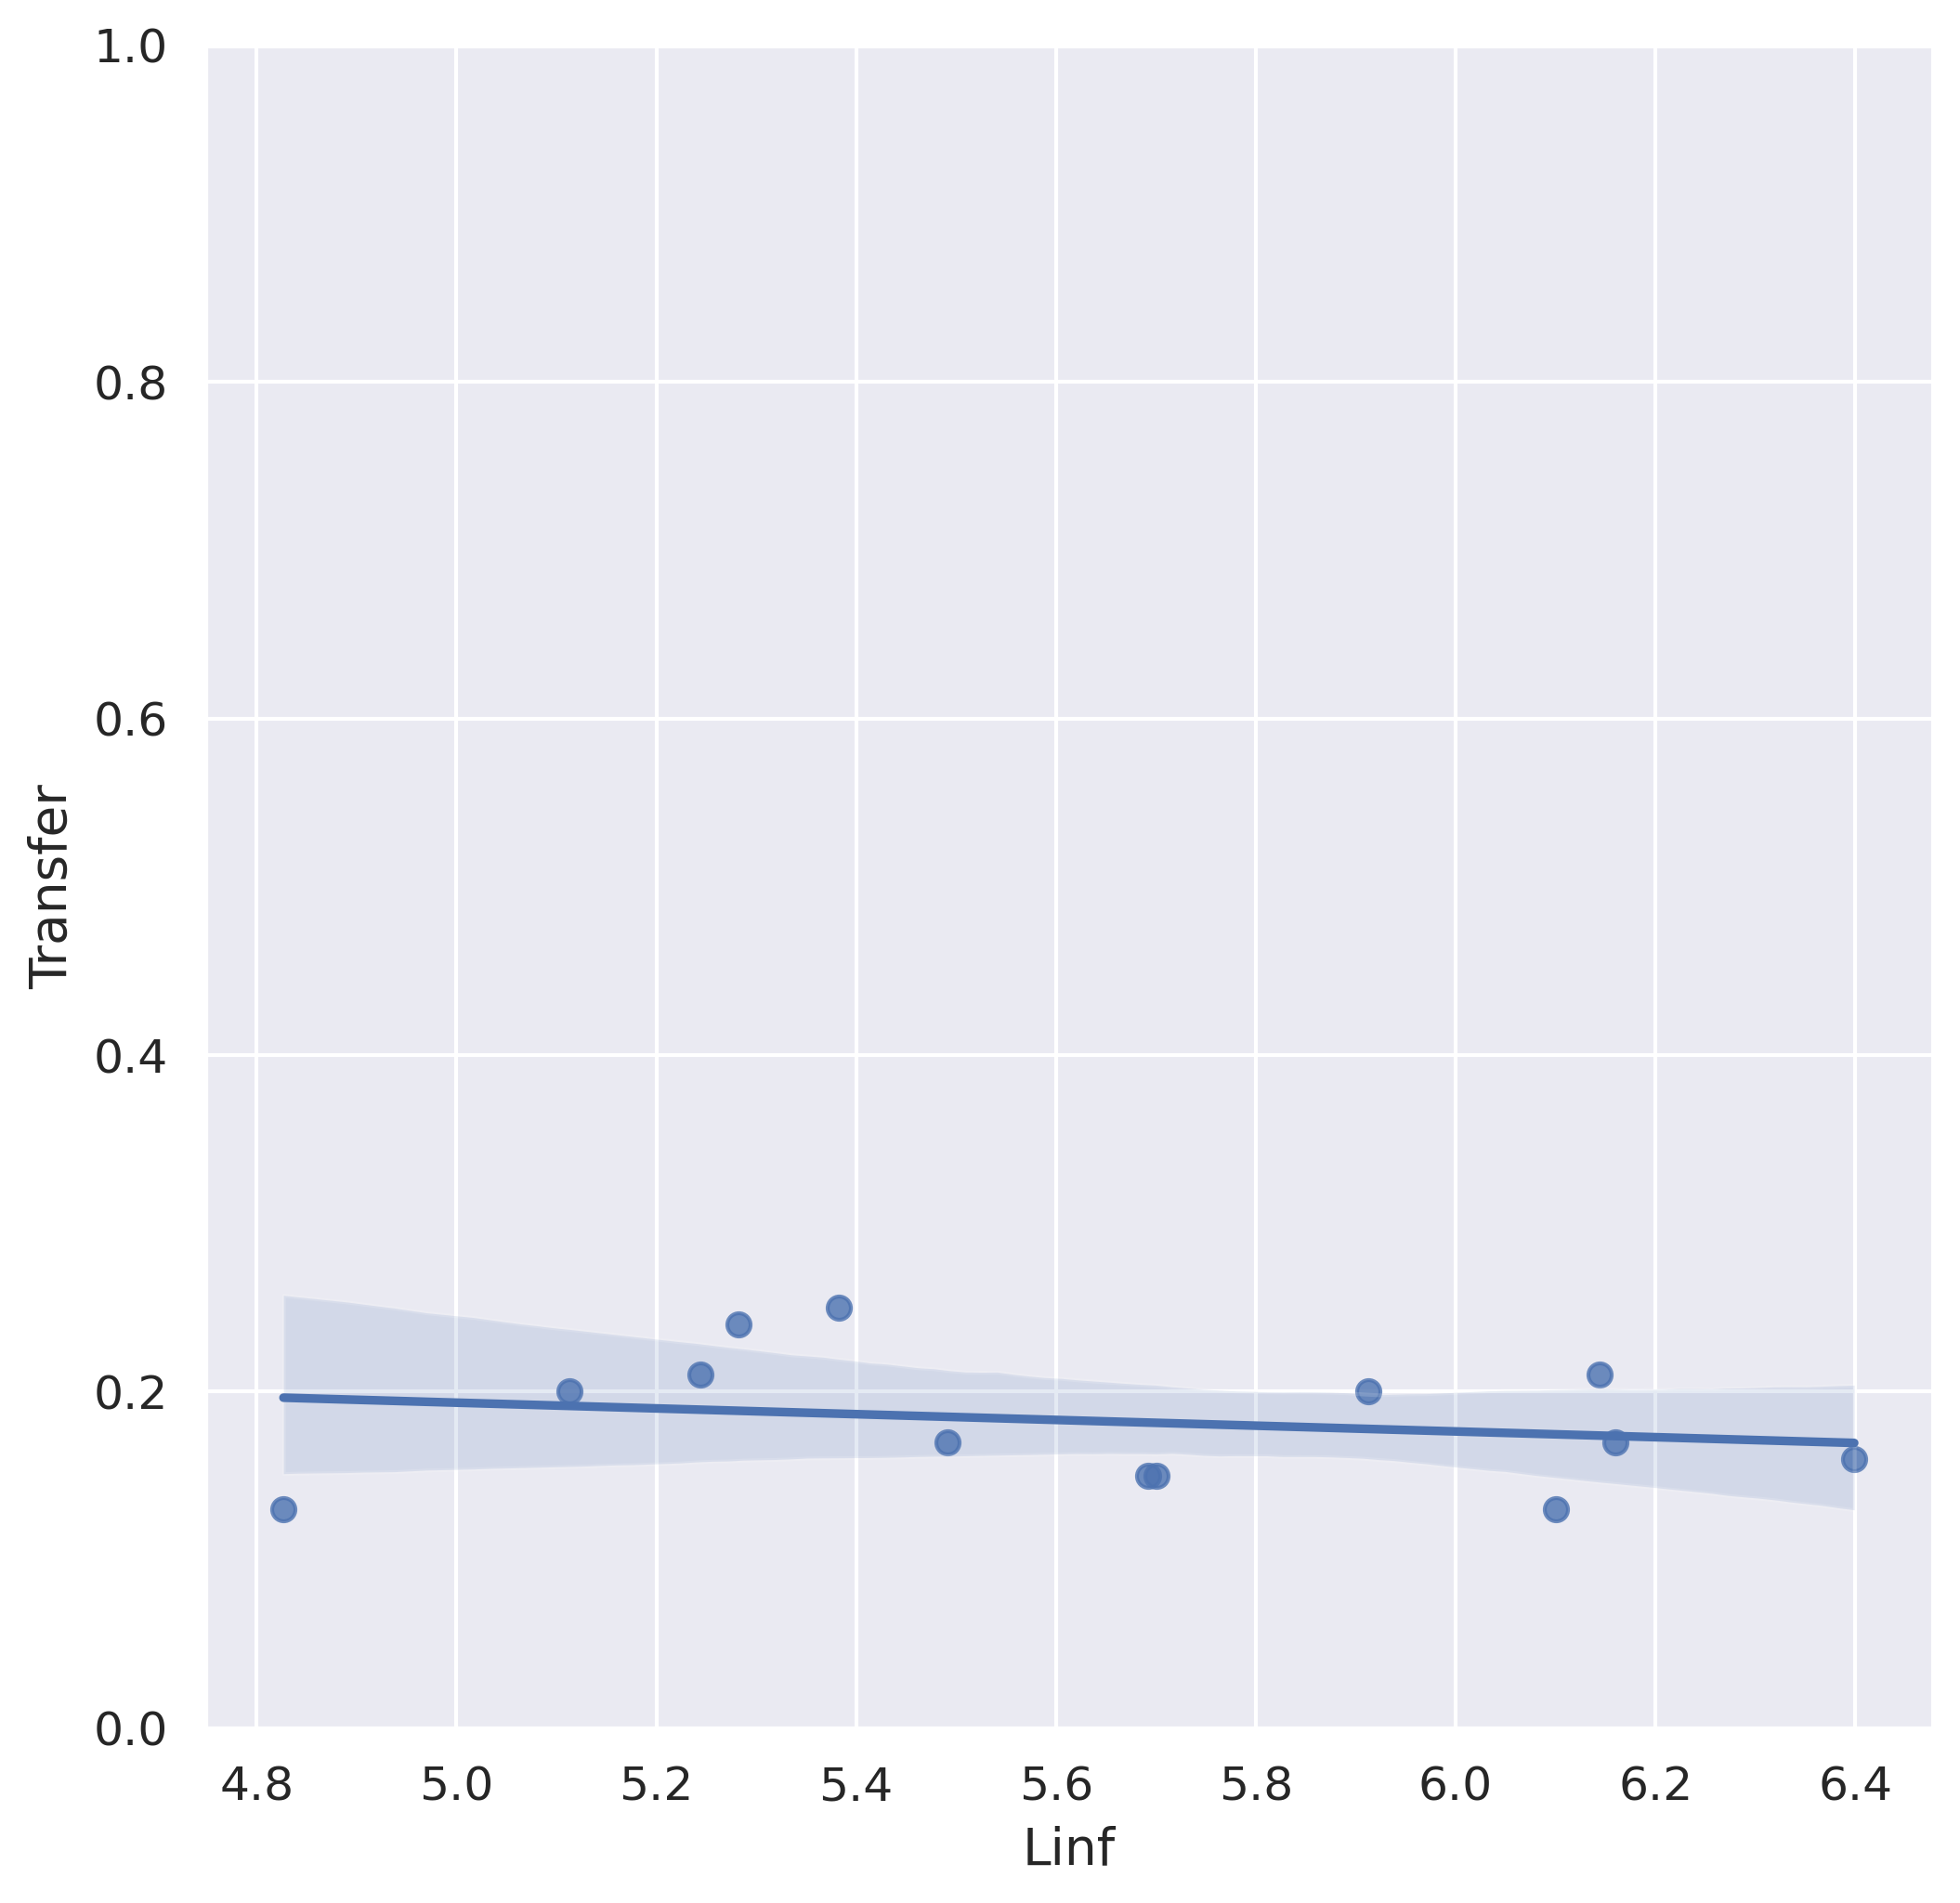

In [50]:
sns.set_style('whitegrid')
sns.set(font_scale=1.1)
plt.figure(figsize=(8, 8), dpi=300)

# Show regression plot
plt.ylim(0, 1)

s = sns.regplot(data=corr_df, y='Transfer', x='Linf', truncate=True, label='L-inf metric')
# s = sns.regplot(data=corr_df, y='Transfer', x='Cosine', truncate=True, label='Cosine metric')
plt.show()